In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew 

plt.style.use('ggplot')

In [65]:
df = pd.read_csv("test.csv", sep=";")


Есть некоторые проблемы с Pressure9am, Pressure3pm. Приведем их к numeric

In [66]:
df["Pressure9am"] = pd.to_numeric(df["Pressure9am"], errors='coerce')
df["Pressure3pm"] = pd.to_numeric(df["Pressure3pm"], errors='coerce')

In [67]:
label = "RainTomorrow"
real_vars = ["MinTemp",
             "MaxTemp",
             "Rainfall",
             "Evaporation",
             "Sunshine",
             "WindGustSpeed",
             "WindSpeed9am",
             "WindSpeed3pm",
             "Humidity9am",
             "Humidity3pm",
             "Pressure9am",
             "Pressure3pm",
             "Cloud9am",
             "Cloud3pm",
             "Temp9am",
             "Temp3pm",
             "RISK_MM"]

cat_vars = ["Location",
             "WindGustDir",
             "WindDir9am",
             "WindDir3pm",
             "RainToday"]

In [68]:
def polarangle(x, y):
        P = 3.14159265358979323846
        q = math.atan2(y, x)
        if q < 0:
            q += 2 * P
        return q

dirdi = {"N": 1,
        "NNE": 2,
        "NE": 3,
        "ENE": 4,
        "E": 5,
        "ESE": 6,
        "SE": 7,
        "SSE": 8,
        "S": 9,
        "SSW": 10,
         "SW": 11,
        "WSW": 12,
        "W": 13,
        "WNW": 14,
        "NW": 15,
        "NNW": 16 }
P = 3.14159265358979323846
def stoa(s):
    if type(s) ==  str:
        return (P * 2.5 - (dirdi[s] - 1) * P / 8) % (P * 2)
    else:
        return s

dat = ["WindDir9am", "WindDir3pm", "WindGustDir"]


def fix_WindDir(x):
    if(pd.isnull(x["WindDir9am"]) != pd.isnull(x["WindDir3pm"])):
        if(pd.isnull(x["WindDir9am"])):
            return x["WindDir3pm"]
        if(pd.isnull(x["WindDir3pm"])):
            return x["WindDir9am"]
        return np.nan

def fix_WindSpeed(x):
    if(pd.isnull(x["WindSpeed9am"]) != pd.isnull(x["WindSpeed3pm"])):
        if(pd.isnull(x["WindSpeed9am"])):
            return x["WindSpeed3pm"]
        if(pd.isnull(x["WindSpeed3pm"])):
            return x["WindSpeed9am"]
        return np.nan

def fix_WindGustDir(x):
    if (pd.isnull(x["WindGustDir"])):
        if(x["WindSpeed9am"] > x["WindSpeed3pm"]):
            return x["WindDir9am"]
        if(x["WindSpeed9am"] <= x["WindSpeed3pm"]):
            return x["WindDir3pm"]
        else:
            return np.nan
    return x["WindGustDir"]

def fix_WindGustSpeed(x):
    if (pd.isnull(x["WindGustSpeed"])):
        return max(x["WindSpeed9am"], x["WindSpeed3pm"])
    return x["WindGustSpeed"]


df.loc[df["WindDir9am"].isnull(), "WindDir9am"] = df[df["WindDir9am"].isnull()].apply(fix_WindDir, axis=1)
df.loc[df["WindDir3pm"].isnull(), "WindDir3pm"] = df[df["WindDir3pm"].isnull()].apply(fix_WindDir, axis=1)

df.loc[df["WindSpeed9am"].isnull(), "WindSpeed9am"] = df[df["WindSpeed9am"].isnull()].apply(fix_WindSpeed, axis=1)
df.loc[df["WindSpeed3pm"].isnull(), "WindSpeed3pm"] = df[df["WindSpeed3pm"].isnull()].apply(fix_WindSpeed, axis=1)

df.loc[df["WindGustDir"].isnull(), "WindGustDir"] = df[df["WindGustDir"].isnull()].apply(fix_WindGustDir, axis=1)
df.loc[df["WindGustSpeed"].isnull(), "WindGustSpeed"] = df[df["WindGustSpeed"].isnull()].apply(fix_WindGustSpeed, axis=1)

df["WindDir9am"] = df["WindDir9am"].apply(stoa)
df["WindDir3pm"] = df["WindDir3pm"].apply(stoa)
df["WindGustDir"] = df["WindGustDir"].apply(stoa)

# Препроцесинг

In [69]:
#Логорифмировать
vars_to_log = ["Rainfall", "Evaporation", "Sunshine", "Pressure3pm", "Pressure9am"]
df[vars_to_log] = df[vars_to_log].apply(lambda w: np.log(w + 1))
#Пожать категориальные 

# Feature extracting

## Temperature delta

In [70]:
df["TDelta"] = (df["MinTemp"] - df["MaxTemp"]).apply(abs)


## PressureDelta

In [71]:
# df["PressureDelta"] = (df["Pressure9am"] - df["Pressure3pm"]).apply(abs)
# df
# df.plot("PressureDelta", "RISK_MM", kind="scatter")

## Year

In [72]:
df['Year']=df['Date'].apply(lambda x: x[:4])

## Season

In [73]:
df["Month"] = df["Date"].apply(str).apply(lambda x: x[5:7]).apply(int)

In [74]:
def monthToSeason(month):
    return month // 4
df["Season"] = df["Month"].apply(monthToSeason)

## Обработаем пропущенные значения
Как будем заполнять? Самый простой вариант, заполнить либо нулями, либо средними, медианными и т.д. значениями. Но очевидно, что влажность, кол-во солнечных дней, облачность - зависят от климматического пояса, и и имеют большую корреляцию, с этим же параметром, в этой же локации, но в предыдущем году

In [75]:
import math
def fixByLocationAndMonth(feature, df):
    evaporationsLM = df[df[feature].isnull() == False].groupby(["Location", "Month"]).describe()[feature]["mean"]
    na_evaporation = df[df[feature].isnull()]

    def FillNAEvaporation(x):
        if (math.isnan(x[feature])):
            try:
                return evaporationsLM[(x["Location"], x["Month"])]
            except:
                try:
                    return evaporationsLM[x["Location"]].mean()
                except:
                    return df[feature].mean()
        else:
            return x[feature]
        
    df[feature] = df.apply(FillNAEvaporation, axis = 1)
    
fixByLocationAndMonth("Evaporation", df)
fixByLocationAndMonth("Sunshine", df)
fixByLocationAndMonth("Cloud9am", df)
fixByLocationAndMonth("Cloud3pm", df)

## Удалим некоторые переменные

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RISK_MM', 'TDelta']
(17601, 22)


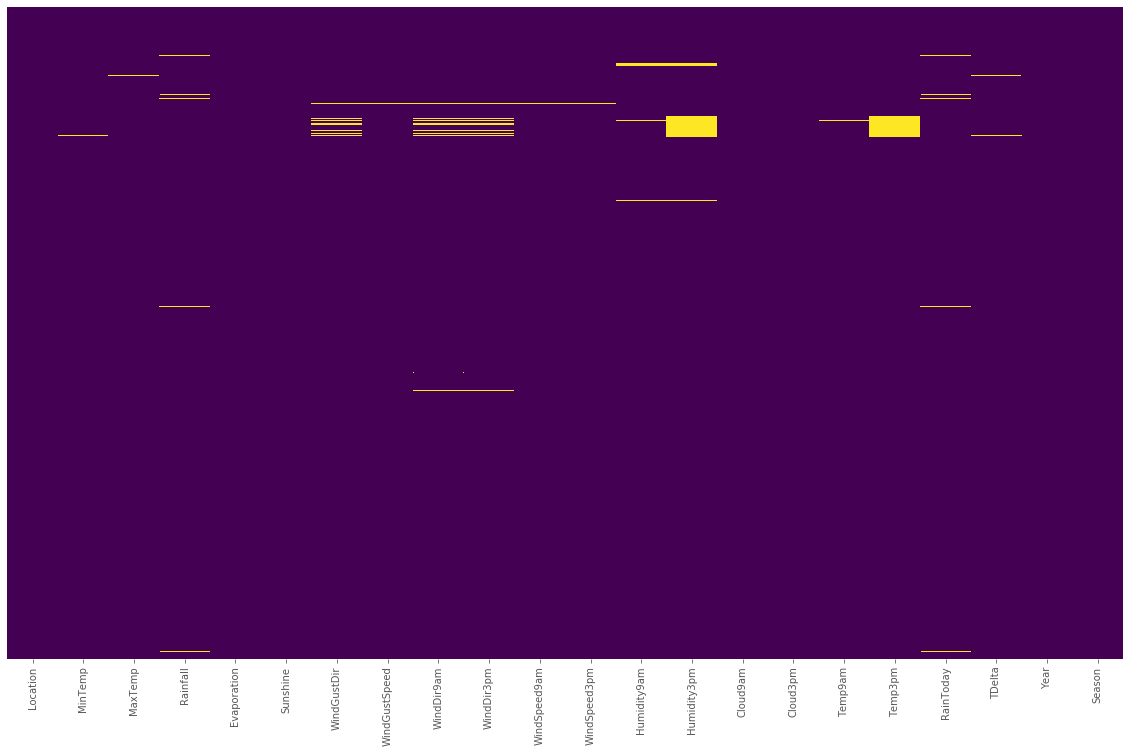

In [76]:
data = df.copy()
real_vars.append("TDelta")
print(real_vars)
to_drop = ["Date", "RISK_MM", "Month", "Pressure3pm", "Pressure9am"]#, "WindDir9am", "WindDir3pm", "WindGustDir"]

data = data.drop(columns = to_drop)
print(data.shape)
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [77]:
data = data.fillna(0)
print(data.shape)

(17601, 22)


## Кластеризация

In [78]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [79]:
knn = KMeans(n_clusters=10)

In [80]:
dataCL = df.copy()
dataCL['Year'] = dataCL['Date'].apply(lambda x: x[:4])

In [81]:
group = dataCL.groupby(['Year','Location'],as_index=False)
res = group.describe()[[('MinTemp','mean'),('MaxTemp','mean'),('Rainfall','mean'),('Humidity9am','mean'),('Humidity3pm','mean')]]
res

,MinTemp,MaxTemp,Rainfall,Humidity9am,Humidity3pm
,mean,mean,mean,mean,mean
0,13.516393,24.044262,0.442064,60.163934,44.147541
1,14.159091,29.442424,0.398593,56.409091,31.136364
2,14.757143,28.392063,0.250521,73.111111,50.253968
3,9.770149,25.289552,0.249486,60.671642,36.805970
4,12.781944,28.608333,0.180240,50.847222,27.611111
...,...,...,...,...,...
85,8.685714,22.922286,0.335287,75.337143,46.588571
86,10.530519,25.672727,0.273810,65.592105,37.136364
87,10.864706,22.828736,0.400492,83.488506,53.166667


In [82]:
res.fillna(0,inplace=True)

In [83]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
scaler.fit(res)
scaled_res = scaler.transform(res)
for_training = pd.DataFrame(scaled_res)

In [84]:
knn.fit(for_training)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [85]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=1, perplexity=30)
tsne_repr=tsne.fit_transform(scaled_res)

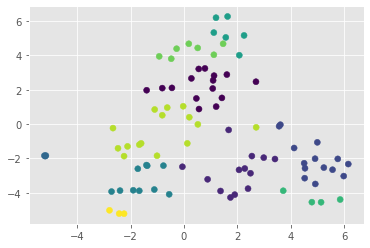

In [86]:
import matplotlib.pyplot as plt
plt.scatter(tsne_repr[:,0],tsne_repr[:,1], c = knn.labels_, cmap = 'viridis')

In [87]:
from sklearn.cluster import AgglomerativeClustering as AGC

agc = AGC(n_clusters=10, affinity='euclidean', linkage='ward')
agc.fit(scaled_res)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=10)

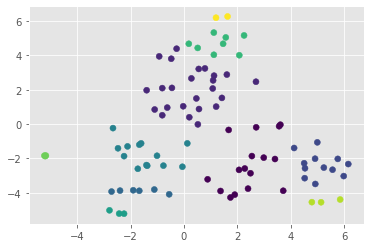

In [88]:
plt.scatter(tsne_repr[:,0],tsne_repr[:,1], c = agc.labels_, cmap = 'viridis')

In [89]:
res['label'] = agc.labels_

In [90]:
group = dataCL.groupby(['Year','Location'])

In [91]:
clusters_df=pd.DataFrame(group.size().reset_index(name = "Group_Count"))
clusters_df['label']=agc.labels_

## Присваиваем лейблы кластеров

In [92]:
labelsDict = {}
for i, row in clusters_df.iterrows():
    labelsDict[(row["Year"], row["Location"])] = row["label"]
    
def get_label(x):
    return labelsDict[(x["Year"], x["Location"])]

data["Label"] = data.apply(get_label, axis = 1)

## one-hot encoding 

In [93]:
data = pd.get_dummies(data, columns = ["Label", "RainToday", "Season"], dummy_na = True).drop(columns = ["Year", "Location"]).dropna()

## export to csv

In [94]:
data.to_csv("test_prepared.csv")